# Importing neceassary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

from imblearn.over_sampling import SMOTE

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2
from scikeras.wrappers import KerasClassifier

C:\Users\logoz\AppData\Local\Temp\ipykernel_42184\2358186885.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Creating the dataframe

In [2]:
def read_csv_create_train_test(test_split, features):
    """
    test_split (input): The percentage of data that will be used to test
    features (input): Can be 'all', 'anova' or 'extratrees'
    """
    # Specify the pattern for your csv files
    csv_files = glob.glob('*.csv')

    # List comprehension to load all csv files into DataFrames
    dataframes = [pd.read_csv(file) for file in csv_files]

    # Concatenate all DataFrames into one
    combined_dataframe = pd.concat(dataframes, ignore_index=True)

    # some columns are totally unproductive so let's remove them
    combined_dataframe.drop(['Sample Count'],axis=1,inplace=True)

    if features == 'all':
        # All features
        X = combined_dataframe.drop(['Movement'],axis=1)
    elif features == 'anova':
        # Features based on ANOVA F-Test
        features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
                    'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
                    'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']
        X = combined_dataframe[features]
        print(X.head())
    elif features == 'extratrees':
        # Feature based on ExtraTreesClassifier
        # features = ['Relative Theta Power', 'Bispectrum Relative Gamma Power', 'Bispectrum Relative Delta Power', 'Entropy', 'Relative Beta Power', 'Bispectrum Relative Mu Power', 'Bispectrum Relative Theta Power', 'Activity', 'Skewness', 'Zero Crossing Rate']
        features = ['Variance', 'Skewness', 'Kurtosis', 'Relative Beta Power', 'Relative Gamma Power', 'Entropy', 'Zero Crossing Rate', 'Complexity', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power']
        X = combined_dataframe[features]
    y = combined_dataframe.Movement

    # Convert labels to one-hot encoding
    y = to_categorical(y)  # Ensure this matches the classes correctly

    # Splitting the dataset into the Training set and Test set. Stratify should keep all classes of movement balanced
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state = 42, stratify=y)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Feature Scaling because we don't want one independent variable dominating the other and it makes computations easy
    sc = StandardScaler()
    X_train_smote = sc.fit_transform(X_train_smote)
    X_test = sc.transform(X_test)

    return combined_dataframe, X_train_smote, X_test, y_train_smote, y_test

# ANOVA F-Test

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif

# df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.2, features='all')

# # Separate features and target
# X = df.drop(['Movement'], axis=1)
# y = df.Movement

# # Store column names
# feature_names = X.columns

# cutoff = 0.3

# # # # Scale the features
# # # scaler = StandardScaler()
# # # X_scaled = scaler.fit_transform(X)

# # Apply ANOVA F-test
# anova_selector = SelectKBest(f_classif, k='all')  # Set k='all' to get scores for all features
# X_kbest = anova_selector.fit_transform(X, y)

# # Get the p-values for each feature
# p_values = anova_selector.pvalues_

# # Print the p-values
# for i, col in enumerate(X.columns):
#     print(f"{col}: ANOVA F-test p-value = {p_values[i]}")

# # List to store features with p-value > 0.2
# features_with_high_p_value = [col for i, col in enumerate(X.columns) if p_values[i] > cutoff]

# # Print the list of features with p-value > 0.2
# print(f"Features with p-value > {cutoff}:", features_with_high_p_value)

# plt.bar(feature_names, p_values, width=0.8, bottom=None, align='center')

# # ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power', 'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power', 'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']

# Extra Trees

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt

# df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.2, features='all')

# # Separate features and target
# X = df.drop(['Movement'], axis=1)
# y = df.Movement

# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) ## use inbuilt class feature_importances of tree based classifiers
# ## plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.title("Top 10 important features in data")
# plt.show()

# # ['Relative Theta Power', 'Bispectrum Relative Gamma Power', 'Bispectrum Relative Delta Power', 'Entropy', 'Relative Beta Power', 'Bispectrum Relative Mu Power', 'Bispectrum Relative Theta Power', 'Activity', 'Skewness', 'Zero Crossing Rate']

# Heatmap

In [ ]:
# # features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
# #             'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
# #             'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']
# # df1 = df[features]

# plt.figure(figsize=(15,15))
# p=sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0)

# Create dataframe

In [3]:
df, X_train, X_test, y_train, y_test = read_csv_create_train_test(test_split=0.2, features='anova')
df

       Mean  Skewness  Kurtosis  Relative Theta Power  Relative Alpha Power  \
0 -0.946220 -1.423580  12.24330              0.000487              0.001732   
1  0.316570 -0.878542   7.89931              0.000070              0.000459   
2 -0.263012 -0.979489   6.98955              0.000039              0.001405   
3  0.207405 -0.807133   5.03191              0.000059              0.000830   
4 -3.727510 -0.422136   6.31267              0.002526              0.006550   

   Relative Beta Power  Relative Gamma Power  Relative Mu Power  Entropy  \
0             0.169863              0.330316           0.000637  1.62404   
1             0.228124              0.279803           0.000315  1.51092   
2             0.136665              0.404064           0.000692  1.94925   
3             0.271614              0.241921           0.000452  2.23038   
4             0.150855              0.343799           0.005523  1.97039   

   Complexity  Bispectrum Relative Theta Power  \
0     36.2659     

,Mean,Variance,Skewness,Kurtosis,Relative Delta Power,Relative Theta Power,Relative Alpha Power,Relative Beta Power,Relative Gamma Power,Relative Mu Power,...,Mobility,Complexity,Bispectrum Relative Delta Power,Bispectrum Relative Theta Power,Bispectrum Relative Alpha Power,Bispectrum Relative Beta Power,Bispectrum Relative Gamma Power,Bispectrum Relative Mu Power,Third Moment,Movement
0,-0.946220,14217.300000,-1.423580,12.24330,0.000335,0.000487,0.001732,0.169863,0.330316,0.000637,...,0.242110,36.265900,1.094910e-06,2.431260e-06,0.000063,0.142116,0.357972,0.000005,-2.413270e+06,1
1,0.316570,14360.400000,-0.878542,7.89931,0.000038,0.000070,0.000459,0.228124,0.279803,0.000315,...,0.224843,36.212300,1.415960e-08,7.072560e-08,0.000003,0.270297,0.232980,0.000002,-1.511870e+06,1
2,-0.263012,12951.300000,-0.979489,6.98955,0.000028,0.000039,0.001405,0.136665,0.404064,0.000692,...,0.252894,33.947000,8.606330e-09,2.168870e-08,0.000037,0.160061,0.432854,0.000010,-1.443670e+06,1
3,0.207405,27399.100000,-0.807133,5.03191,0.000010,0.000059,0.000830,0.271614,0.241921,0.000452,...,0.209135,49.070300,9.353210e-10,9.494350e-08,0.000010,0.298317,0.211006,0.000004,-3.660580e+06,1
4,-3.727510,30306.700000,-0.422136,6.31267,0.002350,0.002526,0.006550,0.150855,0.343799,0.005523,...,0.257851,73.166400,5.696150e-05,6.594100e-05,0.000572,0.174983,0.325361,0.000518,-2.227200e+06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9588,-0.000111,0.011166,0.496470,3.01304,0.000005,0.000025,0.001478,0.257674,0.255149,0.001376,...,0.231763,0.032559,2.107870e-10,1.871360e-08,0.000066,0.358289,0.151813,0.000065,5.857470e-04,3
9589,-0.000275,0.012008,0.469600,3.67404,0.000037,0.000110,0.001824,0.126976,0.374509,0.000690,...,0.258134,0.043326,1.618050e-08,1.917020e-07,0.000081,0.075709,0.424635,0.000009,6.179280e-04,3
9590,-0.000277,0.014170,0.619668,4.16624,0.000026,0.000043,0.002029,0.155083,0.348320,0.000582,...,0.255045,0.036367,7.131830e-09,2.229710e-08,0.000116,0.168768,0.332069,0.000008,1.045270e-03,3
9591,0.000783,0.012281,0.196380,3.73067,0.000256,0.000335,0.001942,0.269216,0.235972,0.001892,...,0.223800,0.033618,3.629470e-07,6.459100e-07,0.000047,0.417143,0.084522,0.000047,2.672570e-04,3


# Training the ANN model

In [4]:
def build_model():
    # Initialising the ANN
    classifier = Sequential()

    # Adding the input layer ##and the first hidden layer
    classifier.add(Dense(units=256, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l1(0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))

    # Adding the second hidden layer
    classifier.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))

    # Adding the output layer
    classifier.add(Dense(units=4, activation='softmax'))  # Change here for multi-class

    # Compiling the ANN
    adam = Adam(learning_rate=0.001)
    sgd = SGD(learning_rate=0.001, momentum=0.9)
    rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
    classifier.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [5]:
model = build_model()

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the ANN on the Training set
model.fit(X_train, y_train, validation_split=0.05, batch_size=16, epochs=500, callbacks=[early_stopping])

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy*100:.2f}%')



Epoch 1/500


456/456 [==============================] - 1s 1ms/step - loss: 3.4392 - accuracy: 0.8538 - val_loss: 2.0558 - val_accuracy: 0.8906
Epoch 2/500
456/456 [==============================] - 0s 1ms/step - loss: 1.4419 - accuracy: 0.8893 - val_loss: 1.0434 - val_accuracy: 0.8958
Epoch 3/500
456/456 [==============================] - 0s 1ms/step - loss: 0.8685 - accuracy: 0.8925 - val_loss: 0.7775 - val_accuracy: 0.8802
Epoch 4/500
456/456 [==============================] - 0s 1ms/step - loss: 0.6704 - accuracy: 0.8937 - val_loss: 0.6146 - val_accuracy: 0.9036
Epoch 5/500
456/456 [==============================] - 0s 1ms/step - loss: 0.6021 - accuracy: 0.8906 - val_loss: 0.6323 - val_accuracy: 0.8828
Epoch 6/500
456/456 [==============================] - 0s 1ms/step - loss: 0.5486 - accuracy: 0.9015 - val_loss: 0.4913 - val_accuracy: 0.9115
Epoch 7/500
456/456 [==============================] - 0s 1ms/step - loss: 0.5187 - accuracy: 0.8976 - val_loss: 0.4859 - val_accuracy: 0.9

# Creating a confusion matrix to visualize how accurate the model is

[[460   6   0  14]
 [ 12 417   0  51]
 [  0   0 480   0]
 [ 11  48   0 420]]


Text(0.5, 23.52222222222222, 'Predicted label')

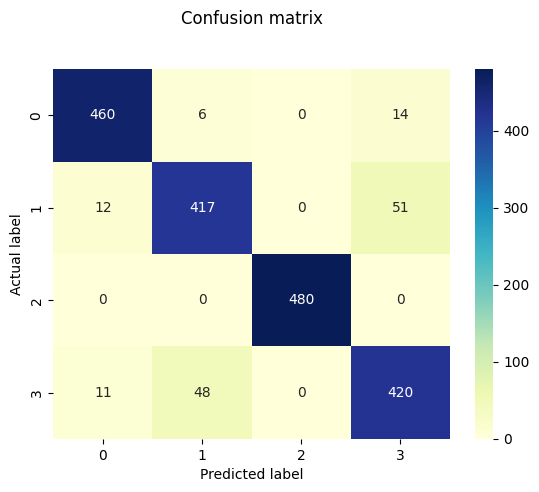

In [6]:
# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Making the Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(cm)

# Plot the confusion matrix
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Classification report

In [7]:
#import classification_report
print(classification_report(y_test_classes,y_pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       480
           1       0.89      0.87      0.88       480
           2       1.00      1.00      1.00       480
           3       0.87      0.88      0.87       479

    accuracy                           0.93      1919
   macro avg       0.93      0.93      0.93      1919
weighted avg       0.93      0.93      0.93      1919



60/60 [==============================] - 0s 593us/step


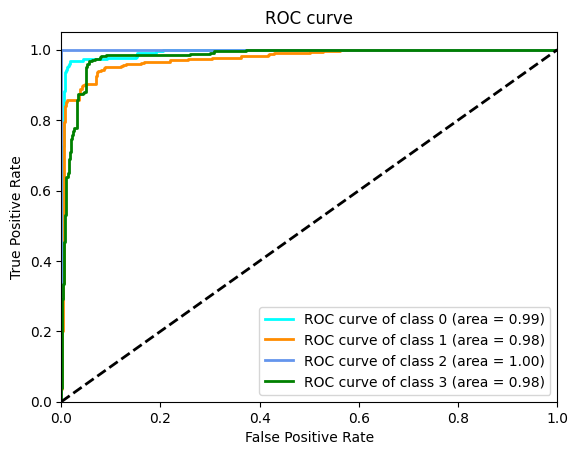

In [8]:
# Assuming your model is 'classifier' and already trained
y_pred_proba = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]  # Assuming y_test is one-hot encoded
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC Curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


# Testing with actual never seen before data

In [9]:
# Predicting the Test set results
test_df_B = pd.read_csv("test/test_B.csv")
test_df_F = pd.read_csv("test/test_F.csv")
test_df_L = pd.read_csv("test/test_L.csv")
test_df_R = pd.read_csv("test/test_R.csv")

In [18]:
features = ['Mean', 'Skewness', 'Kurtosis', 'Relative Theta Power', 'Relative Alpha Power', 'Relative Beta Power',
                    'Relative Gamma Power', 'Relative Mu Power', 'Entropy', 'Complexity', 'Bispectrum Relative Theta Power',
                    'Bispectrum Relative Alpha Power', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power', 'Third Moment']
# features = ['Variance', 'Skewness', 'Kurtosis', 'Relative Beta Power', 'Relative Gamma Power', 'Entropy', 'Zero Crossing Rate', 'Complexity', 'Bispectrum Relative Beta Power', 'Bispectrum Relative Gamma Power']
test_XF = test_df_B[features]
test_XB = test_df_F[features]
test_XL = test_df_L[features]
test_XR = test_df_R[features]

# Feature Scaling because we don't want one independent variable dominating the other and it makes computations easy
sc = StandardScaler()
test_XF_scaled = sc.fit_transform(test_XF)
test_XB_scaled = sc.fit_transform(test_XB)
test_XL_scaled = sc.fit_transform(test_XL)
test_XR_scaled = sc.fit_transform(test_XR)

In [19]:
# testF = model.predict(test_XF)
# testB = model.predict(test_XB)
# testL = model.predict(test_XL)
# testR = model.predict(test_XR)

testF = model.predict(test_XF_scaled)
testB = model.predict(test_XB_scaled)
testL = model.predict(test_XL_scaled)
testR = model.predict(test_XR_scaled)

testF_classes = np.argmax(testF, axis=1)
zeros_array = np.full(len(testF_classes), 0)
testB_classes = np.argmax(testB, axis=1)
ones_array = np.full(len(testB_classes), 1)
testL_classes = np.argmax(testL, axis=1)
twos_array = np.full(len(testL_classes), 2)
testR_classes = np.argmax(testR, axis=1)
threes_array = np.full(len(testR_classes), 3)

full_test_pred = np.concatenate((testF_classes,testB_classes,testL_classes,testR_classes))
full_test_actual = np.concatenate((zeros_array,ones_array,twos_array,threes_array))

1/1 [==============================] - 0s 12ms/step


[[3 3 4 4]
 [0 7 2 5]
 [1 5 5 3]
 [1 5 3 5]]


Text(0.5, 23.52222222222222, 'Predicted label')

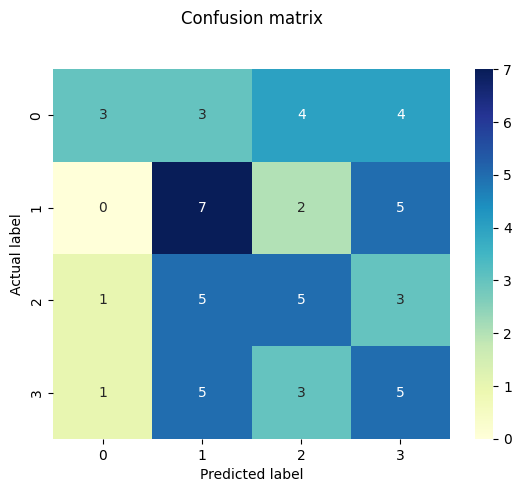

In [20]:
# Making the Confusion Matrix
cm = confusion_matrix(full_test_actual, full_test_pred)
print(cm)

# Plot the confusion matrix
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
#import classification_report
print(classification_report(full_test_actual,full_test_pred))

              precision    recall  f1-score   support

           0       0.60      0.21      0.32        14
           1       0.35      0.50      0.41        14
           2       0.36      0.36      0.36        14
           3       0.29      0.36      0.32        14

    accuracy                           0.36        56
   macro avg       0.40      0.36      0.35        56
weighted avg       0.40      0.36      0.35        56



# Storing model to deploy

In [ ]:
# # Save tensorflow model
# save_model(model=model, filepath='tensorflow', save_format='tf')

In [ ]:
# # Convert to tensorflow lite model
# import tensorflow as tf

# # Load your saved model
# saved_model_dir = 'tensorflow'

# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# tflite_model = converter.convert()

# # Save the converted model
# with open('tflite/model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [ ]:
# import tensorflow as tf

# imported = tf.saved_model.load("tensorflow")
# f = imported.signatures["serving_default"]

# # Create a dummy input tensor with the correct shape (e.g., batch size of 1 and 22 features)
# # row = df.iloc[0].drop('Movement')
# # input_row = row.to_numpy()[np.newaxis, :]
# input_row = X_test[0][np.newaxis, :]

# # Pass the input tensor with the correct argument name
# output = f(dense_input=tf.constant(input_row, dtype=tf.float32))

# output_tensor = output['dense_4']
# probabilities = output_tensor.numpy()[0]

# # Extract the individual probabilities
# prob_forward = probabilities[0]
# prob_backward = probabilities[1]
# prob_left = probabilities[2]
# prob_right = probabilities[3]

# print("Probability Forward:", prob_forward)
# print("Probability Backward:", prob_backward)
# print("Probability Left:", prob_left)
# print("Probability Right:", prob_right)
